#The following code is a combination of the following:

Matterport_MaskRCNN:
@misc{matterport_maskrcnn_2017,
  title={Mask R-CNN for object detection and instance segmentation on Keras and TensorFlow},
  author={Waleed Abdulla},
  year={2017},
  publisher={Github},
  journal={GitHub repository},
  howpublished={\url{https://github.com/matterport/Mask_RCNN}},
}

AND
"Creating a Weapon Detector in 5 simple steps"
https://towardsdatascience.com/plug-and-play-object-detection-code-in-5-simple-steps-f1975804373e



In [1]:
#Change the directory to the MASK_R-CNN folder cloned from the https://github.com/EricR33/MMAI894 Repo

In [2]:
cd '/Users/ericross/School/Queens_MMAI/MMAI/MMAI_894/Team_Project/Python/Mask_R-CNN'

/Users/ericross/School/Queens_MMAI/MMAI/MMAI_894/Team_Project/Python/Mask_R-CNN


In [3]:
#!pip install "git+https://github.com/philferriere/cocoapi.git#egg=pycocotools&subdirectory=PythonAPI"

In [4]:
#!pip install -r requirements.txt

In [5]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

# Root directory of the project
ROOT_DIR = os.getcwd()

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.model import log

#Import COCO config
#import coco
from samples.coco import coco
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version

from pycocotools.coco import COCO

%matplotlib inline 

/Users/ericross/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/ericross/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/ericross/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/ericross/opt/anaconda3/lib/python3.7/site-packages/ten

In [6]:
from glob import glob
import json
# Path to your images
image_paths = glob('Crack_Pictures/*')
#image_paths

from glob import glob
import json
from random import random

#Path to your images
image_paths = glob("Crack_Pictures/*")
#Path to your annotations from VIA tool
annotation_file = 'via_region_data.json'
#clean up the annotations a little
annotations = json.load(open(annotation_file))
cleaned_annotations = {}
for k,v in annotations['_via_img_metadata'].items():
    cleaned_annotations[v['filename']] = v
#create train and validation directories
! mkdir procdata
! mkdir procdata/val
! mkdir procdata/train
train_annotations = {}
valid_annotations = {}
#20% of images in validation folder
for img in image_paths:
    # Image goes to Validation folder
    if random()<0.2:
        os.system("cp "+ img + " procdata/val/")
        img = img.split("/")[-1]
        valid_annotations[img] = cleaned_annotations[img]
    else:
        os.system("cp "+ img + " procdata/train/")
        img = img.split("/")[-1]
        train_annotations[img] = cleaned_annotations[img]
#put different annotations in different folders
with open('procdata/val/via_region_data.json', 'w') as fp:
    json.dump(valid_annotations, fp)
with open('procdata/train/via_region_data.json', 'w') as fp:
    json.dump(train_annotations, fp)

In [7]:
#cp -r samples/balloon samples/cracks

# Configurations

In [8]:
from samples.cracks import cracks

In [9]:
config = cracks.CracksConfig()
CRACKS_DIR = os.path.join(ROOT_DIR, "procdata")

In [10]:
# Load dataset
# Get the dataset from the releases page
# https://github.com/matterport/Mask_RCNN/releases
dataset = cracks.CracksDataset()
dataset.load_cracks(CRACKS_DIR, "train")

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 36
Class Count: 2
  0. BG                                                
  1. crack                                             


In [11]:
dataset.class_names

['BG', 'crack']

In [12]:
dataset.class_ids

array([0, 1])

# Display Samples

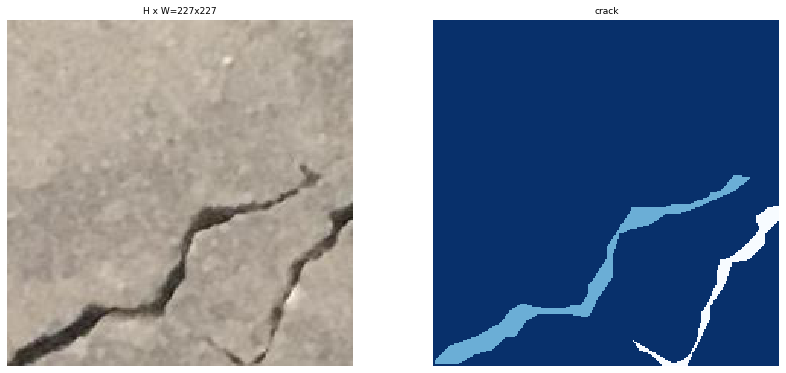

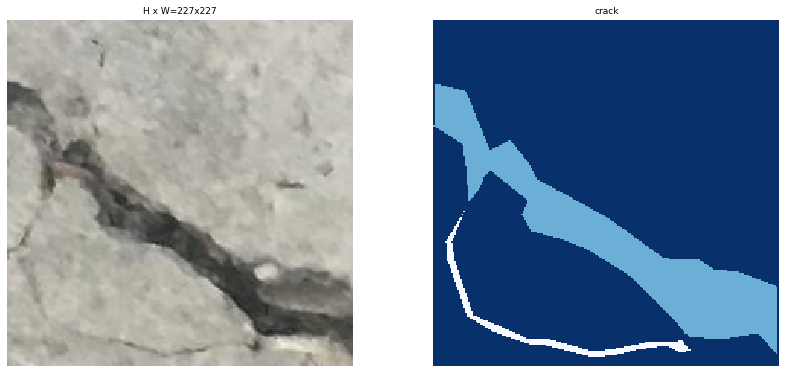

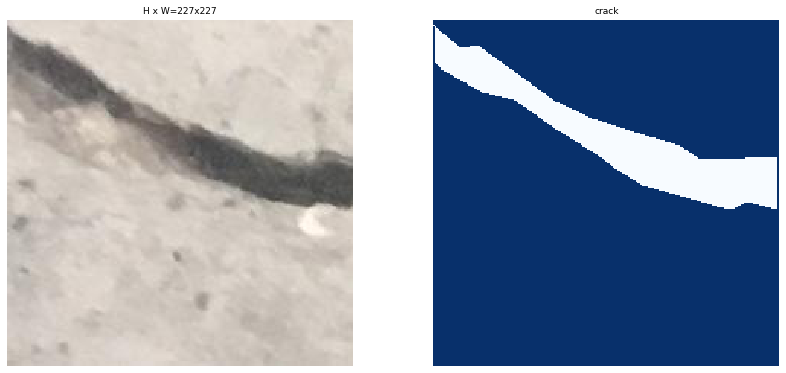

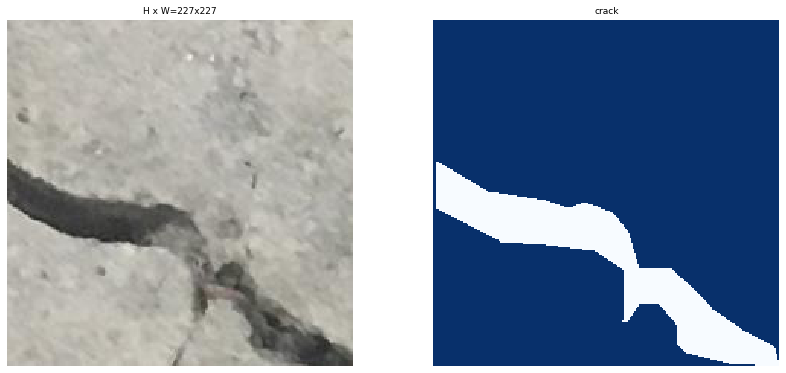

In [13]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    class_ids = [int(x) for x in class_ids]
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names,limit=1)

# Bounding Boxes

In [14]:
from random import choices

image_id  28 /Users/ericross/School/Queens_MMAI/MMAI/MMAI_894/Team_Project/Python/Mask_R-CNN/procdata/train/07196.jpg
image                    shape: (227, 227, 3)         min:   35.00000  max:  255.00000  uint8
mask                     shape: (227, 227, 1)         min:    0.00000  max:    1.00000  bool
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int64
bbox                     shape: (1, 4)                min:    2.00000  max:  226.00000  int32


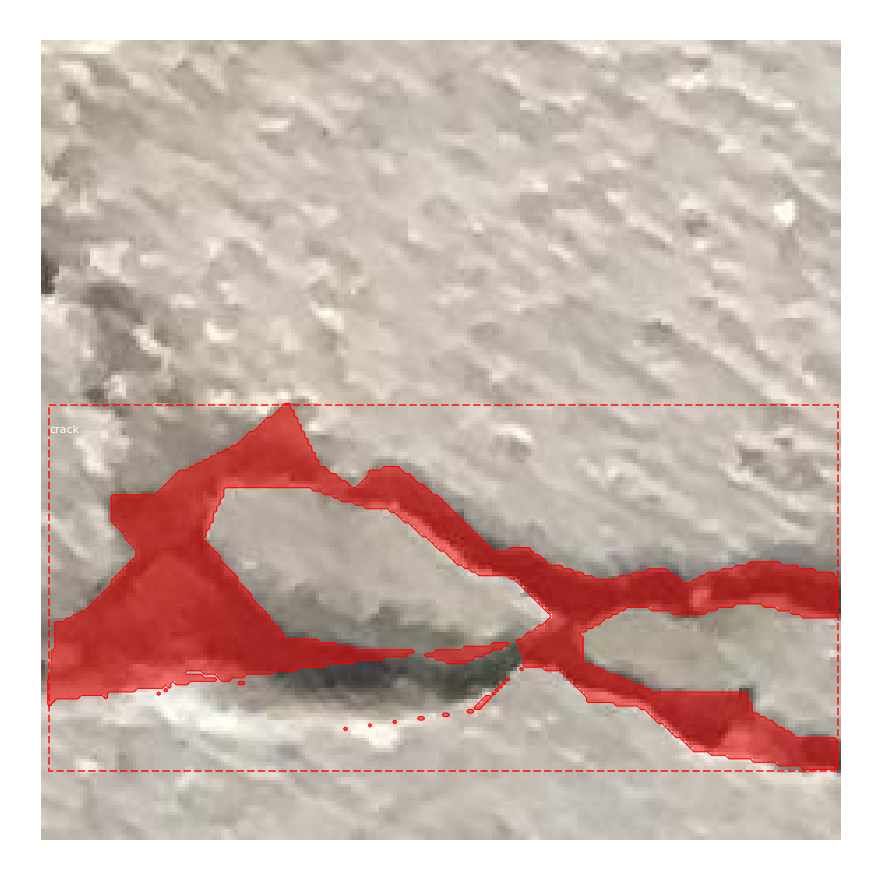

In [15]:
# Load random image and mask.
image_id = np.random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
class_ids = np.array([int(x) for x in class_ids])
# Compute Bounding box
bbox = utils.extract_bboxes(mask)
# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

image_id  23 /Users/ericross/School/Queens_MMAI/MMAI/MMAI_894/Team_Project/Python/Mask_R-CNN/procdata/train/06102.jpg
image                    shape: (227, 227, 3)         min:   22.00000  max:  255.00000  uint8
mask                     shape: (227, 227, 4)         min:    0.00000  max:    1.00000  bool
class_ids                shape: (4,)                  min:    1.00000  max:    1.00000  int64
bbox                     shape: (4, 4)                min:    1.00000  max:  226.00000  int32


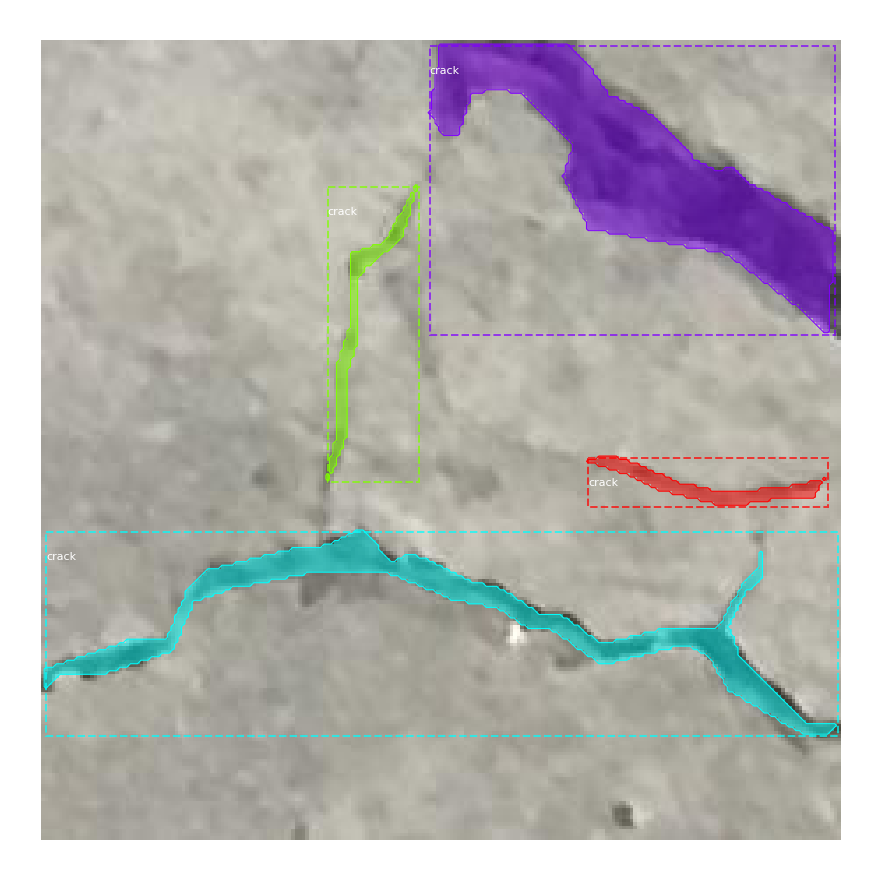

In [16]:
# Load random image and mask.
image_id = np.random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
class_ids = np.array([int(x) for x in class_ids])
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

image_id  9 /Users/ericross/School/Queens_MMAI/MMAI/MMAI_894/Team_Project/Python/Mask_R-CNN/procdata/train/06095.jpg
image                    shape: (227, 227, 3)         min:   30.00000  max:  228.00000  uint8
mask                     shape: (227, 227, 2)         min:    0.00000  max:    1.00000  bool
class_ids                shape: (2,)                  min:    1.00000  max:    1.00000  int64
bbox                     shape: (2, 4)                min:    2.00000  max:  219.00000  int32


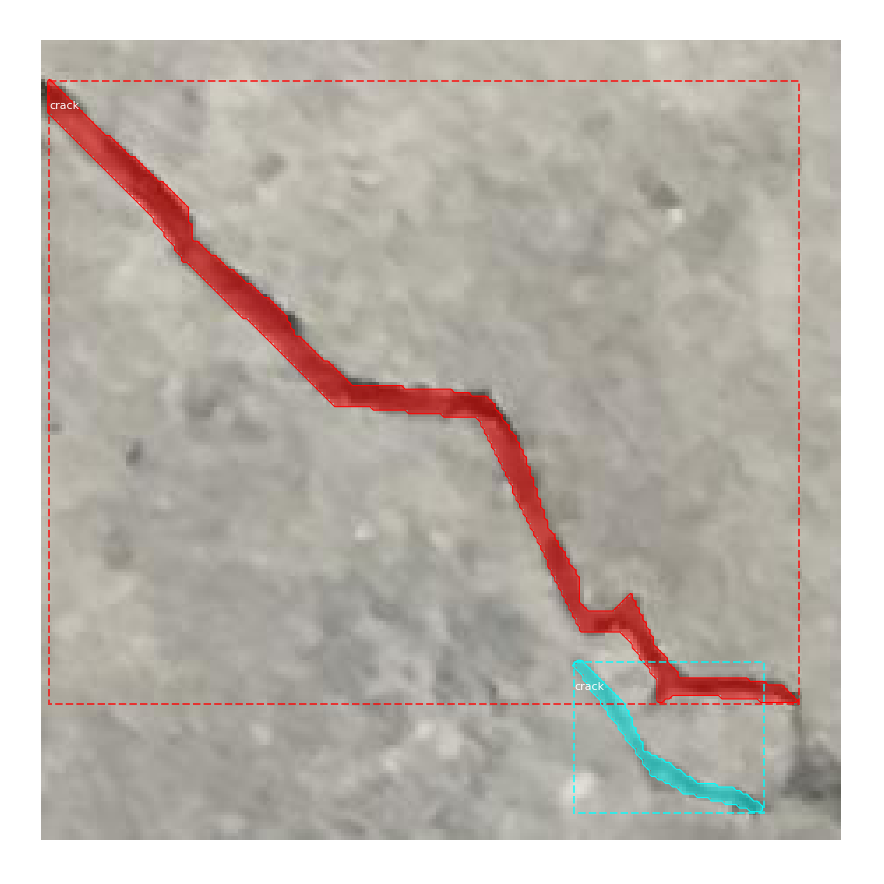

In [17]:
# Load random image and mask.
image_id = np.random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
class_ids = np.array([int(x) for x in class_ids])
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

image_id  34 /Users/ericross/School/Queens_MMAI/MMAI/MMAI_894/Team_Project/Python/Mask_R-CNN/procdata/train/00507.jpg
image                    shape: (227, 227, 3)         min:    9.00000  max:  248.00000  uint8
mask                     shape: (227, 227, 1)         min:    0.00000  max:    1.00000  bool
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int64
bbox                     shape: (1, 4)                min:    3.00000  max:  227.00000  int32


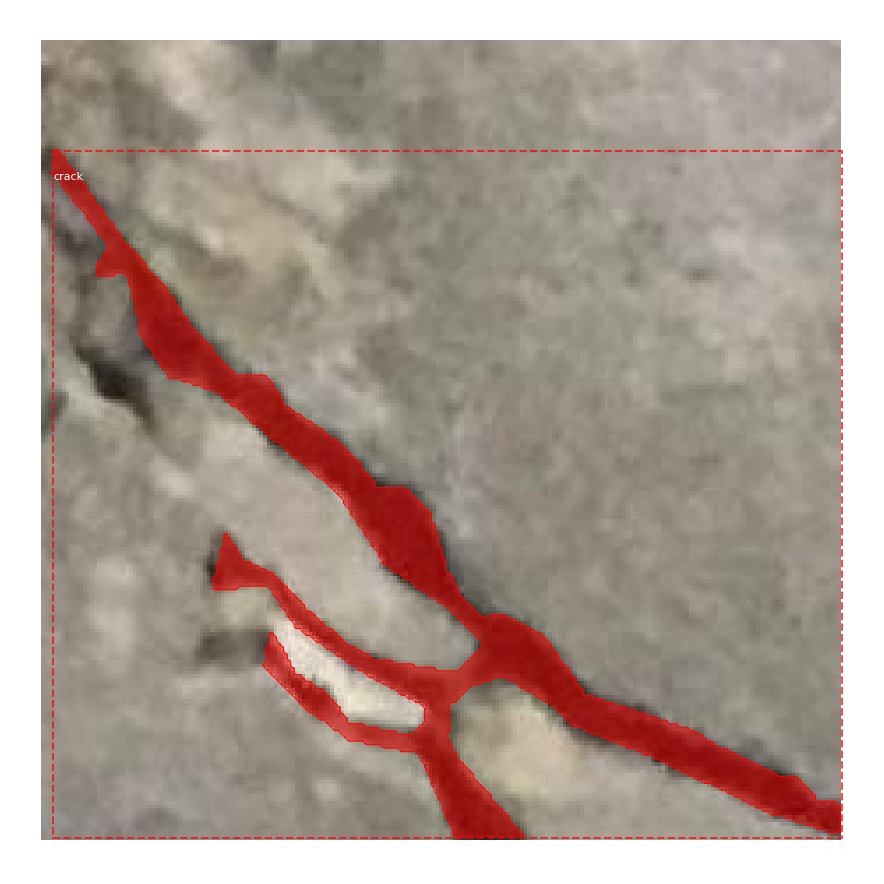

In [18]:
# Load random image and mask.
image_id = np.random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
class_ids = np.array([int(x) for x in class_ids])
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

In [19]:
# Training dataset
dataset_train = cracks.CracksDataset()
dataset_train.load_cracks(CRACKS_DIR, "train")
dataset_train.prepare()

# validation dataset
dataset_val = cracks.CracksDataset()
dataset_val.load_cracks(CRACKS_DIR, "val")
dataset_val.prepare()

# Model Creation

In [20]:
dataset

In [21]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

In [22]:
## Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [23]:
#load the weights for COCO
model.load_weights(os.path.join(ROOT_DIR,'mask_rcnn_coco.h5'), 
                   by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

In [24]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [25]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [26]:
print("Image Count: {}".format(len(dataset_val.image_ids)))

Image Count: 14


# Training

#Train the head branches
#Passing layers="heads" freezes all layers except the head
#layers. You can also pass a regular expression to select
#which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE,
            epochs=3, 
            layers="heads")

# Detection



In [27]:
from mrcnn.config import Config

In [28]:
class CracksConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "crack"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + person_head

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    #DETECTION_MIN_CONFIDENCE = 0.9

In [29]:
class InferenceConfig(CracksConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)



Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /Users/ericross/School/Queens_MMAI/MMAI/MMAI_894/Team_Project/Python/Mask_R-CNN/logs/crack20200219T1610/mask_rcnn_crack_0003.h5
Re-starting from epoch 3


original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  165.00000  uint8
image_meta               shape: (14,)                 min:    1.00000  max: 1024.00000  float64
gt_class_id              shape: (3,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (3, 4)                min:  114.00000  max:  910.00000  int32
gt_mask                  shape: (1024, 1024, 3)       min:    0.00000  max:    1.00000  bool


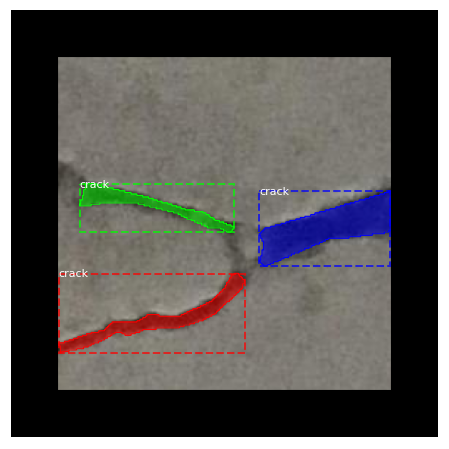

In [30]:
# Test on a random image
image_id = np.random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [31]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  165.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:   52.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32




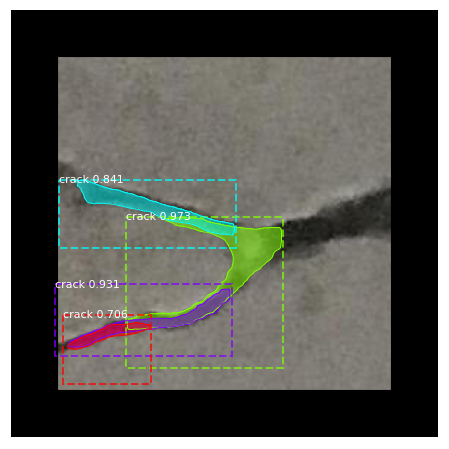

In [32]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

# Evaluation 

In [33]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 5)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.05555555721124013
